- O principal objetivo desse notebook é iniciar um estudo das vendas da EMPRESA para conseguir projetar o faturamento da empresa para os próximos 2 meses

# Imports

In [49]:
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# Data Load

In [50]:
order = pd.read_csv('../data/order.csv')

# 1.0 Descrição dos Dados

In [51]:
df1 = order.copy()

## 1.1 Dimensão dos Dados

In [52]:
df1.shape

(1000, 13)

## 1.2 Tipo dos Dados

In [53]:
df1.dtypes

OrderID            int64
CustomerID         int64
OrderDate         object
OrderStatus       object
ShippedDate       object
ShipAddress       object
Unnamed: 6       float64
Unnamed: 7       float64
Unnamed: 8       float64
ShipCountry       object
ShippingFee      float64
PaymentMethod     object
TotalAmount      float64
dtype: object

- Teremos que trocar o tipo dos dados de OrderDate e ShippedDate

## 1.3 Check NA

In [54]:
df1.isna().sum()

OrderID             0
CustomerID          0
OrderDate           0
OrderStatus         0
ShippedDate         0
ShipAddress         0
Unnamed: 6       1000
Unnamed: 7       1000
Unnamed: 8       1000
ShipCountry         0
ShippingFee         0
PaymentMethod       0
TotalAmount         0
dtype: int64

## 1.4 Change Data Type

In [55]:
df1['OrderDate'] = pd.to_datetime(df1['OrderDate'])

df1['ShippedDate'] = pd.to_datetime(df1['ShippedDate'])

df1.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)

# 2.0 Feature Engineering

In [56]:
df2 = df1.copy()

In [57]:
df2['Year'] = df2['OrderDate'].dt.year
df2['Month'] = df2['OrderDate'].dt.month
df2['Year_Month'] = df2['OrderDate'].dt.to_period('M')

ts_sales = df2[['OrderDate', 'TotalAmount']].sort_values('OrderDate', ascending=True).set_index('OrderDate')

ts_sales['Mes'] = ts_sales.index.to_period('M').to_timestamp()

# Agora, agrupando por essa nova coluna
ts_sales_mes = ts_sales.groupby('Mes').sum()


# 3.0 Exploratory Data Analysis

In [58]:
df3 = df2.copy()

## Business Insights

### Faturamento ao longo do tempo

<Axes: title={'center': 'Faturamento por Ano'}, xlabel='Year', ylabel='TotalAmount'>

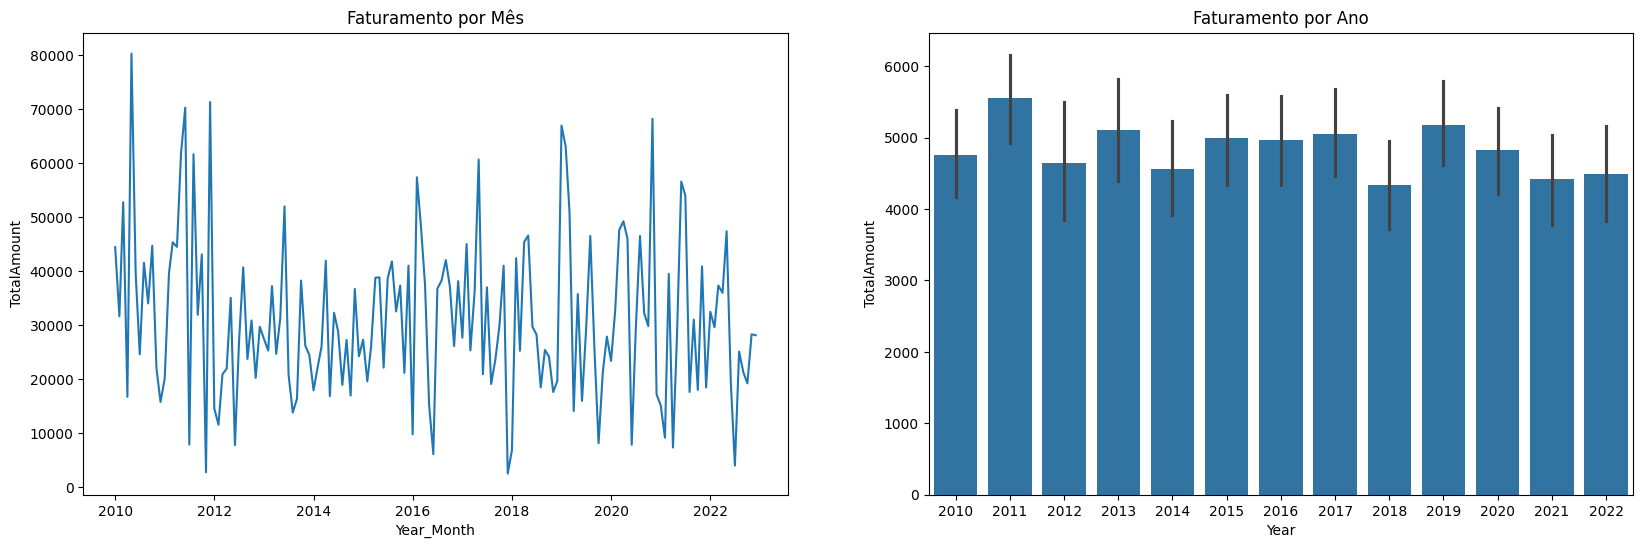

In [59]:
df_faturamento = df3.groupby(['Year_Month'])['TotalAmount'].sum().reset_index()
df_faturamento['Year_Month'] = df_faturamento['Year_Month'].dt.to_timestamp()

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Faturamento por Mês')
sns.lineplot(x='Year_Month', y='TotalAmount', data=df_faturamento)

plt.subplot(1,2,2)
plt.title('Faturamento por Ano')
sns.barplot(x='Year', y='TotalAmount', data=df3)

### Faturamento por País

<Axes: title={'center': 'Top 20 Países com maior faturamento'}, xlabel='ShipCountry', ylabel='TotalAmount'>

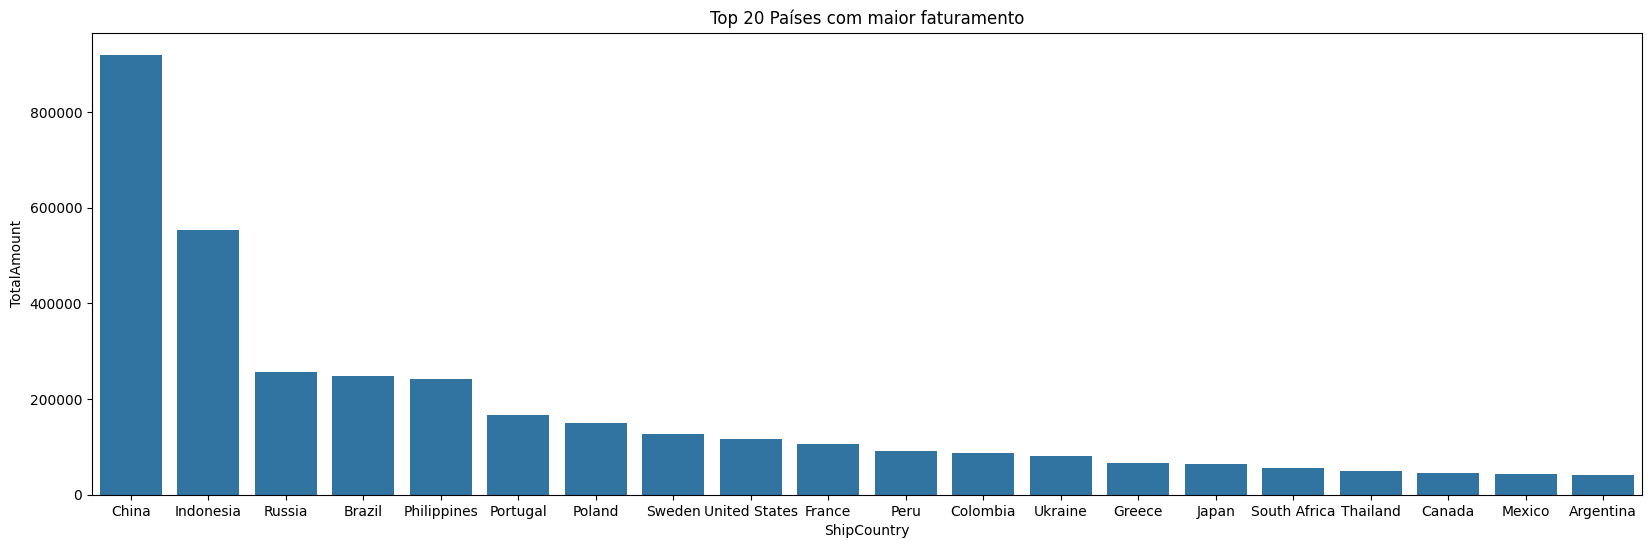

In [60]:

df_country = df3.groupby(['ShipCountry'])['TotalAmount'].sum().reset_index().sort_values('TotalAmount', ascending=False)

plt.figure(figsize=(20,6))
plt.title('Top 20 Países com maior faturamento')
sns.barplot(x='ShipCountry', y='TotalAmount', data=df_country.head(20))

### Faturamento por Tipo de Pagamento

<Axes: xlabel='PaymentMethod', ylabel='TotalAmount'>

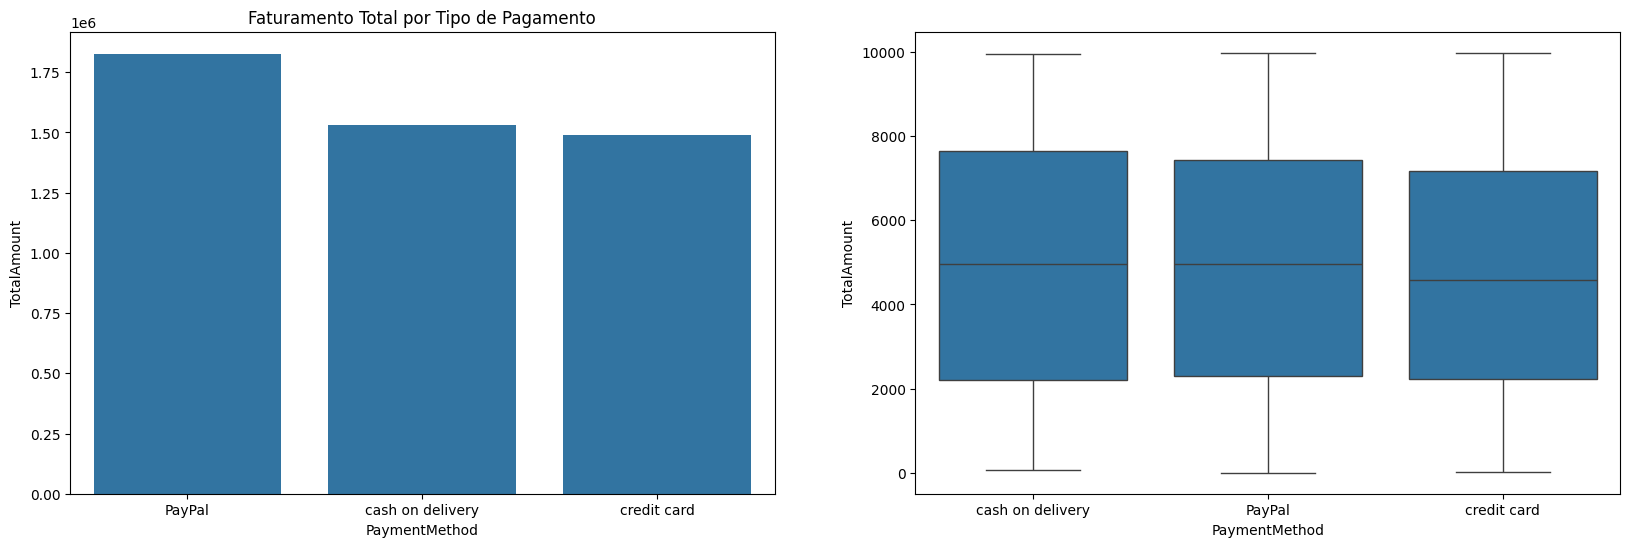

In [61]:

df_type = df3.groupby(['PaymentMethod'])['TotalAmount'].sum().reset_index().sort_values('TotalAmount', ascending=False)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.title('Faturamento Total por Tipo de Pagamento')
sns.barplot(x='PaymentMethod', y='TotalAmount', data=df_type.head(20))

plt.subplot(1,2,2)
sns.boxplot(x='PaymentMethod', y='TotalAmount', data=df3)

### Análise por Status

<Axes: xlabel='OrderStatus', ylabel='TotalAmount'>

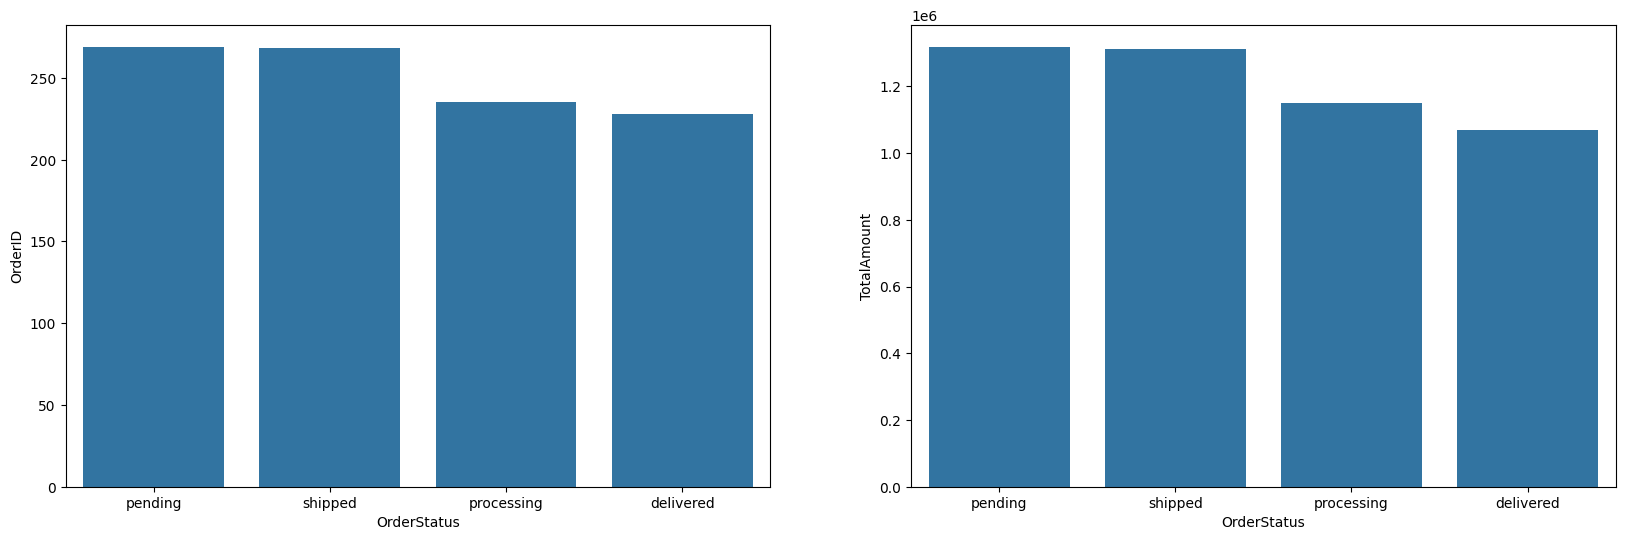

In [62]:
plt.figure(figsize=(20,6))

# quantidade de pedidos por status
orders_status = df3[['OrderID','OrderStatus']].groupby('OrderStatus').count().reset_index().sort_values('OrderID', ascending=False)
plt.subplot(1,2,1)
sns.barplot(x='OrderStatus', y='OrderID', data=orders_status)

# faturamento por status
faturamento_status = df3[['TotalAmount','OrderStatus']].groupby('OrderStatus').sum().reset_index().sort_values('TotalAmount', ascending=False)
plt.subplot(1,2,2)
sns.barplot(x='OrderStatus', y='TotalAmount', data=faturamento_status)



In [63]:
df3.head()

,OrderID,CustomerID,OrderDate,OrderStatus,ShippedDate,ShipAddress,ShipCountry,ShippingFee,PaymentMethod,TotalAmount,Year,Month,Year_Month
0,1,1,2012-02-16,pending,2021-07-10,30249 Donald Way,China,63.95,cash on delivery,1568.28,2012,2,2012-02
1,2,2,2012-02-06,processing,2014-06-23,97 David Street,Greece,75.62,cash on delivery,4654.31,2012,2,2012-02
2,3,3,2013-01-02,pending,2022-10-22,2024 Myrtle Parkway,Poland,453.17,PayPal,5810.01,2013,1,2013-01
3,4,4,2013-02-28,pending,2011-11-22,75158 Merry Plaza,Japan,883.25,PayPal,4388.28,2013,2,2013-02
4,5,5,2014-08-28,delivered,2017-08-16,875 Nancy Hill,Portugal,881.14,credit card,2972.23,2014,8,2014-08


## Time Series Analysis

<Axes: xlabel='Mes'>

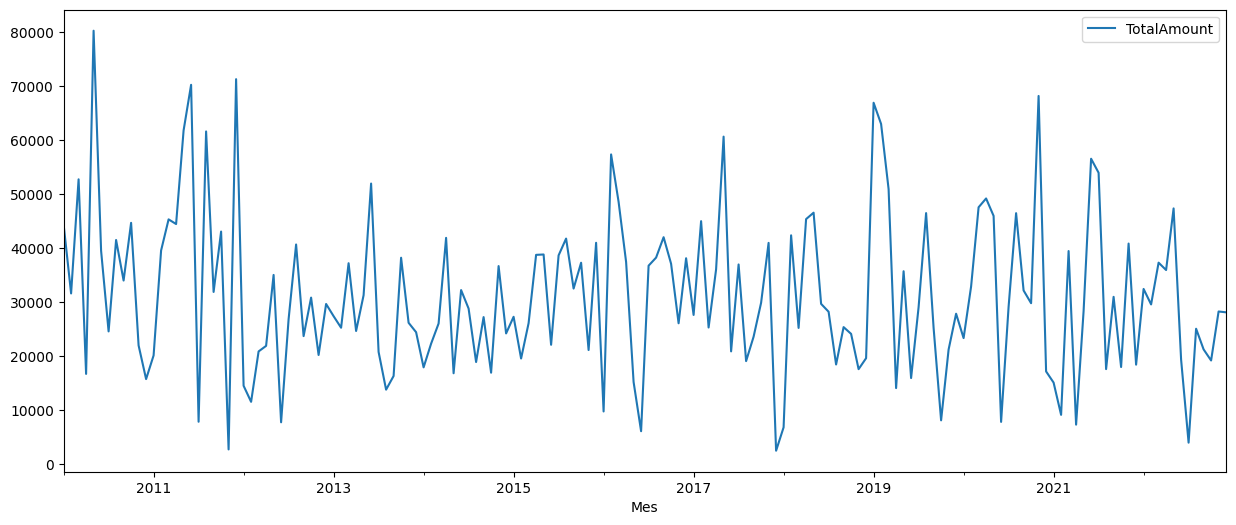

In [66]:
ts_sales_mes.plot(figsize=(15,6))

#### Média Móvel Simples (MMS)

<Axes: xlabel='Mes'>

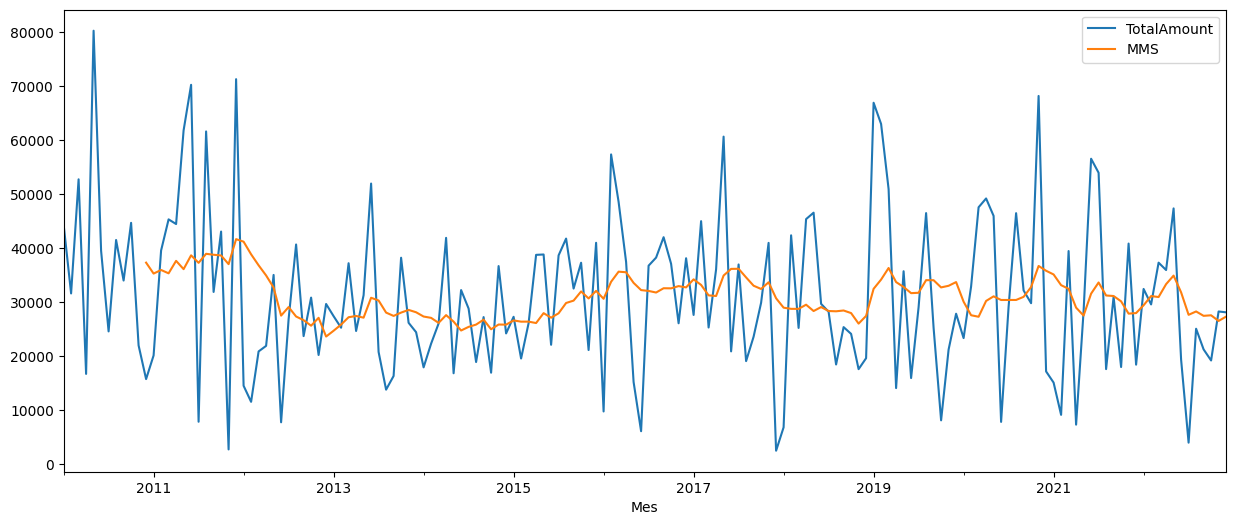

In [104]:
ts_aux = pd.DataFrame(ts_sales_mes['TotalAmount'])
ts_aux['MMS'] = ts_sales_mes.rolling(12).mean()['TotalAmount']

ts_aux.plot(figsize=(15,6))

<Axes: xlabel='OrderDate'>

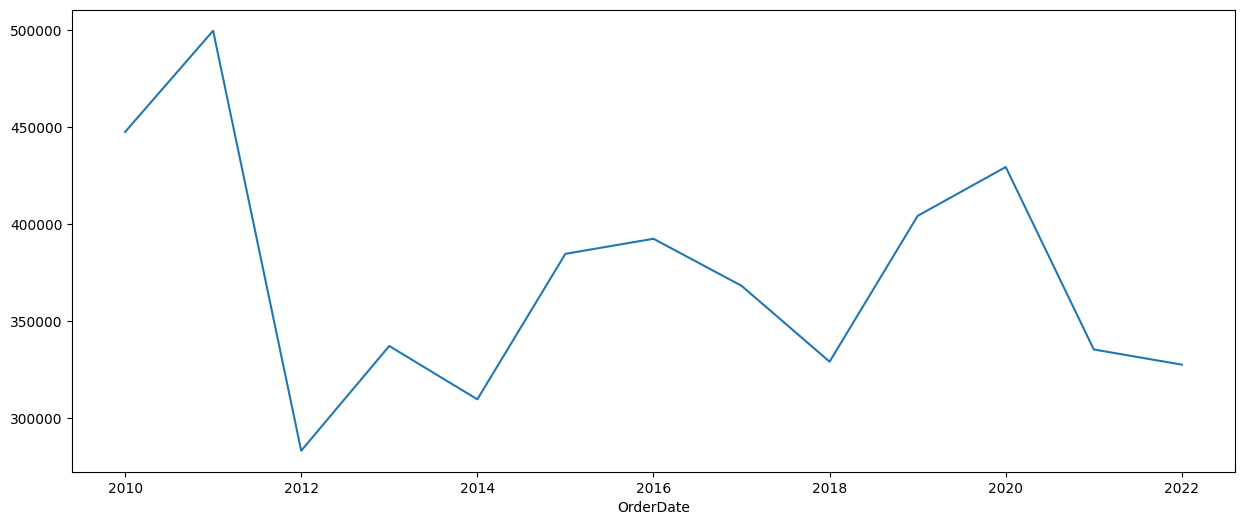

In [105]:
ts_sales.TotalAmount.groupby(ts_sales.index.year).sum().plot(figsize=(15, 6))

#### Análise de Sazonalidade

<Axes: xlabel='Mes'>

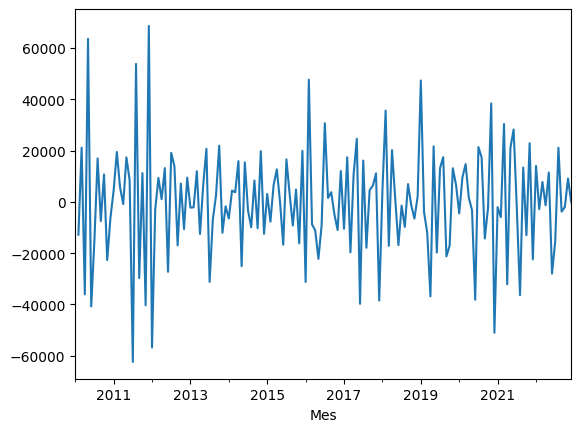

In [123]:
ts_sales_mes.TotalAmount.diff().plot()

<Axes: xlabel='Mes'>

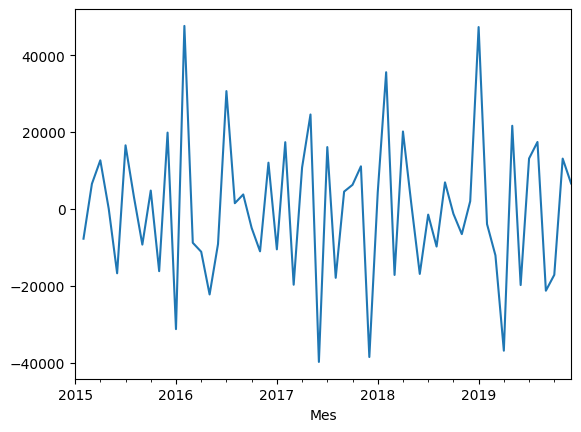

In [121]:
interval = (ts_sales_mes.index.year >= 2015) & (ts_sales_mes.index.year <= 2019)
ts_sales_mes[interval].TotalAmount.diff().plot()

<Axes: xlabel='Mes'>

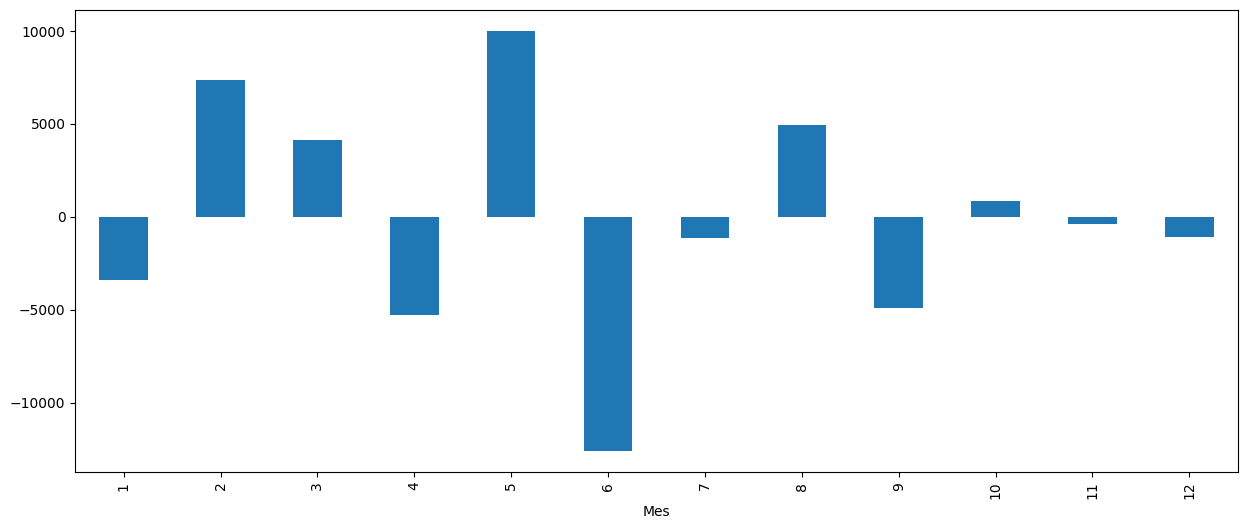

In [126]:
ts_sales_mes.TotalAmount.diff(1).groupby(ts_sales_mes.index.month).mean().plot(kind='bar', figsize=(15,6))